# 3. 카메라 스티커앱 만들기 첫걸음

## 3-1. 카메라 스티커앱 만들기 첫걸음

- 동영상 처리
- 검출
- 키포인트 추정
- 추적
- 카메라 원근

1. 얼굴인식 카메라의 흐름 이해
2. dlib 라이브러리 사용
3. 이미지 배열의 인덱싱 예외 처리

## 3-2. 어떻게 만들까? 사진 준비하기

스티커를 세밀하고 자연스럽게 적용하기 위해서는 눈, 코, 입, 귀와 같은 얼굴 각각의 위치를 아는 것이 중요하다.
이 위치들을 찾아내는 기술을 **랜드마크(landmark)** 또는 **조정(alignment)**이라고 한다. 조금 더 큰 범위로는 keypoint detection이ㅏ 부른다.


1. 얼굴이 포함된 사진 준비
2. 사진으로부터 얼굴 영역(face landmark)를 찾아낸다. (landmark를 찾기 위해서는 얼굴의 bounding box를 먼저 찾아야 한다)
3. 찾아진 영역으로부터 머리에 왕관 스티커르 붙여본다.

### 사진을 준비하자

**무료 이미지**
- [https://pixabay.com/](https://pixabay.com/)
- [https://unsplash.com/](https://unsplash.com/)

**디렉토리 세팅**
```
$ mkdir -p ~/aiffel/camera_sticker/models
$ mkdir -p ~/aiffel/camera_sticker/images
```
```
aiffel
├── camera_sticker
        └── models
        └── images
                └── image.png
```

**라이브러리 설치**
```
$ pip install opencv-python
$ pip install cmake
$ pip install dlib
```

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

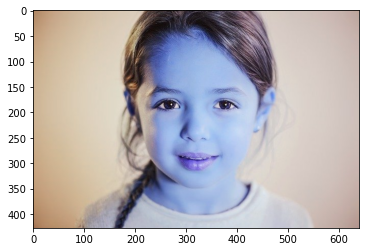

In [2]:
import os

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image-2.png'

img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
# img_bgr = cv2.resize(img_bgr, (800, 1200))    # 이미지 비율에 맞게 resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

- OpenCV에서는 `RGB`가 아닌 `BGR`을 사용한다.

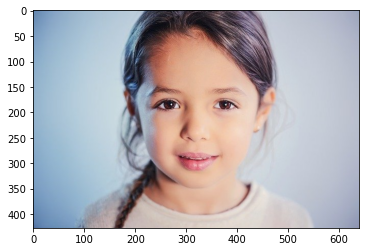

In [3]:
# rgb로 출력
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

- [이미지 다루기 - gramman 0.1 documentation](https://opencv-python.readthedocs.io/en/latest/doc/01.imageStart/imageStart.html)

- `cv2.imread('img.png', 0)`에서 `0`의 의미
    - 이미지 읽기에는 세 가지 옵션 `1, 0, -1`이 있는데 순서대로 다음과 같다.
        - `cv2.IMREAD_COLOR` : 이미지 파일을 Color로 읽어들입니다. 투명한 부분은 무시되며, Default값입니다.
        - `cv2.IMREAD_GRAYSCALE` : 이미지를 Grayscale로 읽어 들입니다. 실제 이미지 처리시 중간단계로 많이 사용합니다.
        - `cv2.IMREAD_UNCHANGED` : 이미지파일을 alpha channel까지 포함하여 읽어 들입니다.

## 3-3. 얼굴 검출 face detection
- [딥러닝(Deep Learning)을 사용한 최신 얼굴 인식(Face Recognition) (한국어 번역본)](https://medium.com/@jongdae.lim/%EA%B8%B0%EA%B3%84-%ED%95%99%EC%8A%B5-machine-learning-%EC%9D%80-%EC%A6%90%EA%B2%81%EB%8B%A4-part-4-63ed781eee3c)
- [Machine Learning is Fun! Part 4: Modern Face Recognition with Deep Learning (영어 원본)](https://medium.com/@ageitgey/machine-learning-is-fun-part-4-modern-face-recognition-with-deep-learning-c3cffc121d78)
    - [이미지로부터 HOG 표현을 생성하고 확인할 수 있는 코드](https://gist.github.com/ageitgey/1c1cb1c60ace321868f7410d48c228e1)
    - [얼굴 랜드마크 찾는 코드](https://gist.github.com/ageitgey/ae340db3e493530d5e1f9c15292e5c74)
    - [이미지를 변형하는 코드](https://gist.github.com/ageitgey/82d0ea0fdb56dc93cb9b716e7ceb364b)
    
**이미지에서 그레디언트(gradient)를 특징(feature)로 사용하는 이유?**
픽셀의 RGB값 자체보다는 인접한 픽셀들 사이의 색상 변화율 자체에 오브젝트의 특징이 더욱 정확히 반영될 때가 많기 때문이다. 예를 들어, 동일한 오브젝트라도 밝을 때와 어두울 때의 픽셀값의 분포는 완전히 다르지만, 밝기가 변하는 방향(그래디언트)만 고려하면 주변 상황과 무관하게 동일한 표현(representation)을 얻을 수 있다.

**단일 픽셀의 그레이언드를 사용하지 않고 16x16의 정사각형을 이용하는 이유?**
단일 픽셀의 그래디언트만 다루면 너무 자세하여 나무만 보고 숲을 보지 못하게 될 수가 있다. 이미지의 기본 패턴을 알려면 픽셀보다는 높은 수준에서의 밝음/어둠의 기본 흐름을 보는 것이 더 좋기 때문이다.

---
- [OpenFace](https://cmusatyalab.github.io/openface/)


In [4]:
# dlib을 활용해 hog detector 선언
import dlib
detector_hog = dlib.get_frontal_face_detector() # detector 선언

In [5]:
# detector를 이용해서 얼굴의 bounding box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1) # (image, num of img pyramid)

- 이미지를 upsamplig 방법을 통해 크기를 키우는 것을 이미지 피라미드라 한다. 이미지 피라미트에서 얼굴을 다시 검출하면 작게 촬영된 얼굴을 크게 볼 수 있기 때문에 더 정확한 검출이 가능하다.
    - [Image Pyramids - gramman 0.1 documentation](https://opencv-python.readthedocs.io/en/latest/doc/14.imagePyramid/imagePyramid.html)

rectangles[[(216, 118) (439, 341)]]


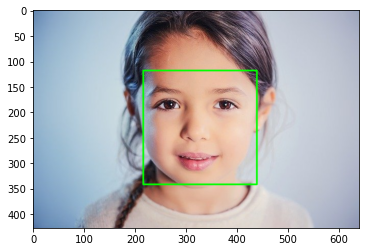

In [6]:
# 찾은 얼굴을 화면에 출력
print(dlib_rects) # 찾은 얼굴 영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l, t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

- dlib detector는 `dlib.rectangles` 타입의 객체를 반환한다.
- `dlib.rectangles`는 `dlib.rectangle` 객체의 배열 형태로 이루어져 있다.
- `dlib.rectangle` 객체는 `left(), top(), right(), bottom(), height(), width()` 등의 멤버 함수를 포함하고 있다.
- [Classes - dlib documentation](http://dlib.net/python/index.html#dlib.rectangles)

## 3-4. 얼굴 랜드마크 face landmark

스티커를 섬세하게 적용하기 위해서는 이목구비 위치를 아는 것이 중요하다. 이목구비 위치를 추론하는 것을 **face landmark localization** 기술이라고 한다.

**face landmark**는 detection의 결과물인 bounding box로 잘라낸(crop) 얼굴 이미지를 사용한다.

**Object keypoint estimation 알고리즘**
Face landmark와 같이 객체 내부의 점을 찾는 기술을 **object keypoint estimation**이라고 한다. keypoint를 찾는 알고리즘은 크게 2가지로 나누어진다.
1. top-down: bounding box를 찾고 box 내부의 keypoint를 예측
2. bottom-up: 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

이번 예제에서는 1번 방식을 다룬다.

### Dlib landmark localization

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/E-8-8.png)
Dlib에 사용 되는 랜드마크 순서는 위와 같다. 이 때 점의 개수는 데이터셋과 논문마다 다르다. 

- [AFLW dataset](https://www.tugraz.at/institute/icg/research/team-bischof/lrs/downloads/aflw/)
- [300-W 데이터셋](https://ibug.doc.ic.ac.uk/resources/facial-point-annotations/)
- [One Millisecond Face Alignment with an Ensemble of Regression Trees](https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Kazemi_One_Millisecond_Face_2014_CVPR_paper.pdf)

Dlib는 ibug 300-W 데이터셋으로 학습한 pretrained model을 제공한다. 학습 알고리즘은 regression tree의 앙상블 모델을 사용했따.

**Dlib의 제공되는 모델 사용**
```
$ wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
$ mv shape_predictor_68_face_landmarks.dat.bz2 ~/aiffel/camera_sticker/models
$ cd ~/aiffel/camera_sticker && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2
```

In [7]:
# 저장한 landmark 모델 불러오기
import os

model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

- `landmark_predictor` 는 RGB 이미지와 `dlib.rectangle`을 입력 받아 `dlib.full_object_detection` 를 반환한다.

In [21]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts())) # 한 사람의 랜드마크
    list_landmarks.append(list_points) # 2중 리스트 (여러 사람)
    
# print(list_points)
# print(list_landmarks)
    
print(len(list_landmarks[0]))

[(204, 184), (208, 214), (215, 243), (223, 270), (235, 296), (253, 315), (276, 331), (299, 345), (324, 350), (349, 345), (374, 332), (399, 316), (419, 294), (431, 270), (438, 240), (443, 210), (447, 180), (222, 164), (237, 152), (258, 150), (278, 153), (297, 160), (342, 159), (362, 153), (381, 151), (401, 153), (419, 162), (319, 184), (319, 203), (319, 222), (318, 241), (301, 254), (310, 258), (320, 261), (331, 258), (341, 256), (245, 188), (258, 178), (275, 178), (288, 190), (274, 193), (257, 193), (354, 190), (367, 178), (383, 179), (396, 188), (384, 193), (368, 193), (281, 285), (296, 282), (311, 278), (320, 281), (331, 279), (347, 283), (366, 286), (348, 305), (332, 312), (321, 313), (310, 312), (296, 305), (287, 288), (311, 288), (321, 290), (331, 289), (359, 288), (331, 296), (320, 297), (311, 296)]
[[(204, 184), (208, 214), (215, 243), (223, 270), (235, 296), (253, 315), (276, 331), (299, 345), (324, 350), (349, 345), (374, 332), (399, 316), (419, 294), (431, 270), (438, 240), (

- `points` 는 `dlib.full_object_detection` 의 객체이기 때문에 `parts()` 함수로 개별 위치에 접근할 수 있습니다. 
- 조금 더 직관적인 (x, y) 형태로 접근할 수 있도록 변환해 주었습니다. 
- 따라서 `list_points` 는 tuple `(x, y)` 68개로 이루어진 리스트가 됩니다. 
- 이미지에서 찾아진 얼굴 개수마다 반복하면 `list_landmark`에 68개의 랜드마크가 얼굴 개수만큼 저장됩니다.

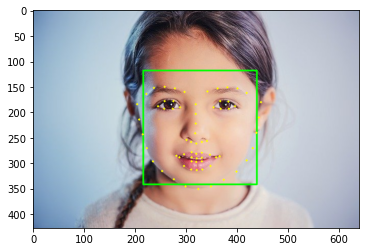

In [9]:
# 랜드마크를 영상에 출력
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 3-5. 스티커 적용하기
랜드마크를 기준으로 '눈썹  위 얼굴 중앙'에 스티커를 씌우면 된다. 구현 방법은 여러가지가 있다. 

코 중심을 기준으로 높이 `x` 이상에 그려도 되고 눈썹 위 `n` 픽셀 위에 스티커를 구현해도 된다.

중요한 것은 얼굴 위치, 카메라의 거리에 따라 픽셀 `x`가 다르기 때문에 비율로 계산을 해줘야 한다. 

계산할 수치는 두 가지이다. 
1. 스티커의 위치
$$x = x_{nose}$$
$$y = y_{nose} - {{height} \over {2}}$$
2. 스티커의 크기
$${width} = {height} = {width}_{bbox}$$

In [24]:
print(list_landmarks)
print(dlib_rects)

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    # 이마 가운데
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width() // 2
    
    # 스티커의 크기
    w = dlib_rect.width()
    h = dlib_rect.width()
    
    print(f"이마 가운데: ({x}, {y})")
    print(f"스티커의 크기: ({w}, {h})")

[[(204, 184), (208, 214), (215, 243), (223, 270), (235, 296), (253, 315), (276, 331), (299, 345), (324, 350), (349, 345), (374, 332), (399, 316), (419, 294), (431, 270), (438, 240), (443, 210), (447, 180), (222, 164), (237, 152), (258, 150), (278, 153), (297, 160), (342, 159), (362, 153), (381, 151), (401, 153), (419, 162), (319, 184), (319, 203), (319, 222), (318, 241), (301, 254), (310, 258), (320, 261), (331, 258), (341, 256), (245, 188), (258, 178), (275, 178), (288, 190), (274, 193), (257, 193), (354, 190), (367, 178), (383, 179), (396, 188), (384, 193), (368, 193), (281, 285), (296, 282), (311, 278), (320, 281), (331, 279), (347, 283), (366, 286), (348, 305), (332, 312), (321, 313), (310, 312), (296, 305), (287, 288), (311, 288), (321, 290), (331, 289), (359, 288), (331, 296), (320, 297), (311, 296)]]
rectangles[[(216, 118) (439, 341)]]
(318, 241)
이마 가운데: (318, 129)
스티커의 크기: (224, 224)


(224, 224, 3)


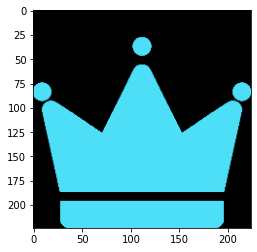

In [11]:
# 스티커의 이미지 읽어오기
import os

sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.png'
img_sticker = cv2.imread(sticker_path)

img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커의 크기를 얼굴 랜드마크 크기로 resize
print (img_sticker.shape)
plt.imshow(img_sticker)
plt.show()

In [12]:
# 스티커를 시작 위치
refined_x = x - w // 2  # left
refined_y = y - h       # top

print(f"이미지에서 스티커 시작 좌표(top-left): ({refined_x}, {refined_y})")

이미지에서 스티커 좌표(top-left): (206, -95)


- 이미지 시작점은 `top-left` 좌표이다. 이미지에 스티커 이미지를 추가하기 위해서 `x`, `y` 좌표를 조정해준다. 

In [13]:
# -y 크기만큼 스티커를 crop
img_sticker = img_sticker[-refined_y:] # 이미지 범위 밖 스티커 제거
print (img_sticker.shape)

(129, 224, 3)


- opencv 데이터는 numpy ndarray 형태의 데이터를 사용한다.
- ndarray는 음수 인덱스에 접근할 수 없기 때문에 음수에 대한 예외 처리를 해줘야 한다.
- 따라서 그림에서 보시는 것처럼 원본 이미지의 범위를 벗어난 스티커 부분을 제거해 주어야 한다.

In [14]:
# top의 y 좌표는 원본 이미지의 경계 값으로 수정한다.
refined_y = 0 # 경계 위치
print(f"이미지에서 스티커 좌표(이마 중심): ({refined_x}, {refined_y})")

이미지에서 스티커 좌표(이마 중심): (206, 0)


(129, 224, 3)


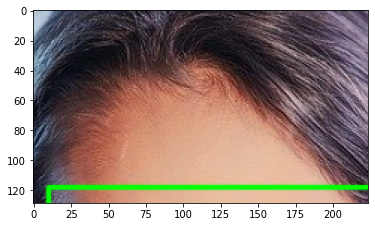

In [15]:
# 원본 이미지에 스티커를 적용한다

# 원본 이미지에서 스티커를 적용할 위치 crop
sticker_area = img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
plt.imshow(cv2.cvtColor(sticker_area, cv2.COLOR_BGR2RGB))

# plt.show()
print(sticker_area.shape)

plt.imshow(cv2.cvtColor(sticker_area, cv2.COLOR_RGB2BGR))

In [16]:
img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

- sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지이다.
- 스티커 이미지에서 사용할 부분은 0 이 아닌 색이 있는 부분을 사용한다.
    - 따라서 `np.where`를 통해 `img_sticker` 가 0 인 부분은 `sticker_area`를 사용하고 0이 아닌 부분을 `img_sticker`를 사용하면 된다.

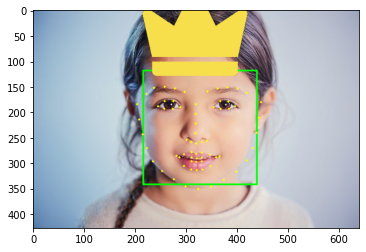

In [17]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

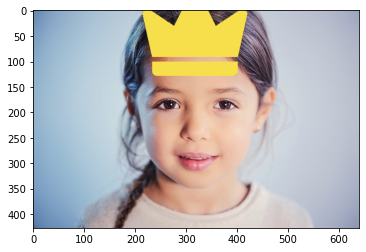

In [18]:
sticker_area = img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))

plt.show()